In [144]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from nam.config import defaults
from nam.data import FoldedDataset
from nam.data import NAMDataset
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams
import pandas as pd

In [145]:
config = defaults()
config.batch_size = 32
config.num_epochs = 1

In [146]:
# load training data
from preprocessing import preprocess_hf_for_nam, PREPROCESSED_COLUMN_NAMES
VAL_SPLIT = 0.2
heart_failure = pd.read_csv("heart_failure/train_val_split.csv")
# heart_failure['target'] = labels
preprocessed, labels = preprocess_hf_for_nam(heart_failure)
x1 = pd.DataFrame(preprocessed, columns=PREPROCESSED_COLUMN_NAMES)
y1 = pd.DataFrame(labels, columns=["HeartDisease"])
frames = [x1, y1]
result = pd.concat(frames, axis=1)

dataset = NAMDataset(config, data_path=result, features_columns=PREPROCESSED_COLUMN_NAMES, targets_column=["HeartDisease"])
dataset.setup_dataloaders(val_split=VAL_SPLIT, test_split=0)

In [147]:
train_dataloaders = dataset.train_dataloaders()
model = NAM(
  config=config,
  name="NAM",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
print(get_num_units(config, dataset.features))

[98, 128, 408, 4, 230, 100, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/torch/nn/init.py:205: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b, generator=generator)


In [148]:
for fold, (trainloader, valloader) in enumerate(train_dataloaders):

    # tb_logger = TensorBoardLogger(save_dir=config.logdir,
    #                             name=f'{model.name}',
    #                             version=f'fold_{fold + 1}')

    # checkpoint_callback = ModelCheckpoint(filename=tb_logger.log_dir +
    #                                     "/{epoch:02d}-{val_loss:.4f}",
    #                                     monitor='val_loss',
    #                                     save_top_k=config.save_top_k,
    #                                     mode='min')

    litmodel = LitNAM(config, model)
    trainer = pl.Trainer(max_epochs=config.num_epochs, log_every_n_steps=1)
                    #    checkpoint_callback=checkpoint_callback)
    trainer.fit(litmodel, trainloader, valloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 110 K 
-------------------------------
110 K     Trainable params
0         Non-trainable params
110 K     Total params
0.442     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Accuracy_metric_epoch             1.0
     test_loss_epoch         70.42095184326172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


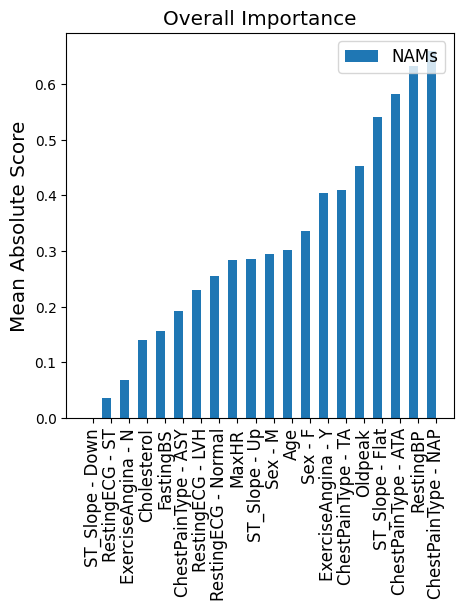

In [149]:
from nam.utils.graphing import plot_mean_feature_importance, calc_mean_prediction


heart_failure_test = pd.read_csv("heart_failure/test_split.csv")
# heart_failure['target'] = labels
preprocessed, labels = preprocess_hf_for_nam(heart_failure_test)
x1 = pd.DataFrame(preprocessed, columns=PREPROCESSED_COLUMN_NAMES)
y1 = pd.DataFrame(labels, columns=["HeartDisease"])
frames = [x1, y1]
result = pd.concat(frames, axis=1)
dataset = NAMDataset(config, data_path=result, features_columns=PREPROCESSED_COLUMN_NAMES, targets_column=["HeartDisease"])
dataset.setup_dataloaders(val_split=0, test_split=0)
trainer.test(litmodel, test_dataset.train_dl)

fig = plot_mean_feature_importance(litmodel.model, dataset)